In [49]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium

from folium import plugins
from humanfriendly import format_timespan

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('./export_11620080/activities.csv')

In [3]:
# inspect data
df.head()

,Activity ID,Activity Date,Activity Name,Activity Type,Activity Description,Elapsed Time,Distance,Max Heart Rate,Relative Effort,Commute,Activity Gear,Filename,Athlete Weight,Bike Weight,Elapsed Time.1,Moving Time,Distance.1,Max Speed,Average Speed,Elevation Gain,Elevation Loss,Elevation Low,Elevation High,Max Grade,Average Grade,Average Positive Grade,Average Negative Grade,Max Cadence,Average Cadence,Max Heart Rate.1,Average Heart Rate,Max Watts,Average Watts,Calories,Max Temperature,Average Temperature,Relative Effort.1,Total Work,Number of Runs,Uphill Time,Downhill Time,Other Time,Perceived Exertion,"<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.type"">Type</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.start_time"">Start Time</span>",Weighted Average Power,Power Count,Prefer Perceived Exertion,Perceived Relative Effort,Commute.1,Total Weight Lifted,From Upload,Grade Adjusted Distance,Weather Observation Time,Weather Condition,Weather Temperature,Apparent Temperature,Dewpoint,Humidity,Weather Pressure,Wind Speed,Wind Gust,Wind Bearing,Precipitation Intensity,Sunrise Time,Sunset Time,Moon Phase,Bike,Gear,Precipitation Probability,Precipitation Type,Cloud Cover,Weather Visibility,UV Index,Weather Ozone,"<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.jump_count"">Jump Count</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.total_grit"">Total Grit</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.avg_flow"">Avg Flow</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.flagged"">Flagged</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.avg_elapsed_speed"">Avg Elapsed Speed</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.dirt_distance"">Dirt Distance</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.newly_explored_distance"">Newly Explored Distance</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.newly_explored_dirt_distance"">Newly Explored Dirt Distance</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.sport_type"">Sport Type</span>"
0,405687930,"Oct 3, 2015, 9:41:14 PM",Afternoon Run at Prospect Park,Run,NaN,1802,5.83,NaN,NaN,False,NaN,activities/405687930.gpx,55.338299,NaN,1802.0,1778.0,5835.799805,11.6,NaN,27.604900,NaN,18.100000,49.099998,13.000000,-0.015422,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,406566915,"Oct 4, 2015, 10:52:47 PM",Evening Run Before Movie,Run,NaN,1117,3.08,NaN,NaN,False,NaN,activities/406566915.gpx,55.338299,NaN,1117.0,1054.0,3084.699951,6.9,NaN,39.685398,NaN,9.700000,48.500000,22.799999,0.794243,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,407791541,"Oct 6, 2015, 10:12:20 PM",Evening Run Before Movie Coming Home,Run,NaN,2956,8.89,NaN,NaN,False,NaN,activities/407791541.gpx,55.338299,NaN,29

In [4]:
# preprocessing - removing html tags from columns
df.columns = df.columns.str.replace(r'<[^<>]*>', '', regex=True)

In [5]:
cols = df.columns.values.tolist()
for k, v in enumerate(cols):
    print(k, v)

0 Activity ID
1 Activity Date
2 Activity Name
3 Activity Type
4 Activity Description
5 Elapsed Time
6 Distance
7 Max Heart Rate
8 Relative Effort
9 Commute
10 Activity Gear
11 Filename
12 Athlete Weight
13 Bike Weight
14 Elapsed Time.1
15 Moving Time
16 Distance.1
17 Max Speed
18 Average Speed
19 Elevation Gain
20 Elevation Loss
21 Elevation Low
22 Elevation High
23 Max Grade
24 Average Grade
25 Average Positive Grade
26 Average Negative Grade
27 Max Cadence
28 Average Cadence
29 Max Heart Rate.1
30 Average Heart Rate
31 Max Watts
32 Average Watts
33 Calories
34 Max Temperature
35 Average Temperature
36 Relative Effort.1
37 Total Work
38 Number of Runs
39 Uphill Time
40 Downhill Time
41 Other Time
42 Perceived Exertion
43 Type
44 Start Time
45 Weighted Average Power
46 Power Count
47 Prefer Perceived Exertion
48 Perceived Relative Effort
49 Commute.1
50 Total Weight Lifted
51 From Upload
52 Grade Adjusted Distance
53 Weather Observation Time
54 Weather Condition
55 Weather Temperature


In [7]:
# converting date from string to datetime
df['activity_date'] = pd.to_datetime(df['Activity Date'], infer_datetime_format=True)

# converting from metric to imperial units for American context
# convert Distance column from default (km) to miles
df['Distance'] = df['Distance'].replace(',', '').astype(float)
df['distance_mile'] = df['Distance'] * 0.621371

# convert Elevation Gain from meter to feet
df['Elevation Gain'] = df['Elevation Gain'].replace(',', '').astype(float)
df['elevation_gain_ft'] = df['Elevation Gain'] * 3.28084

In [14]:
# select date range in 2022
mask = (df['activity_date'] > '2022-01-01') & (df['activity_date'] <= '2022-12-31')
df = df.loc[mask]

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'Weight Training'),
  Text(1, 0, 'Run'),
  Text(2, 0, 'Workout'),
  Text(3, 0, 'Hike'),
  Text(4, 0, 'Yoga'),
  Text(5, 0, 'Kayaking'),
  Text(6, 0, 'Walk'),
  Text(7, 0, 'Ride')])

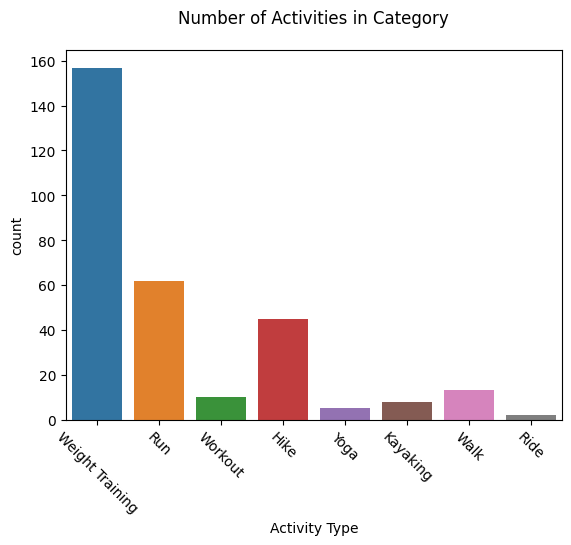

In [15]:
# activity categories
g = sns.countplot(x='Activity Type', data=df)

g.set_title('Number of Activities in Category', y=1.05)

plt.xticks(rotation=-45)

In [16]:
# number of activities
len(df)

302

In [17]:
# number of active days
len(df.groupby([df['activity_date'].dt.date]))

218

In [18]:
# adding new column month 
df['activity_month'] = df['activity_date'].dt.month
df['activity_day'] = df['activity_date'].dt.day

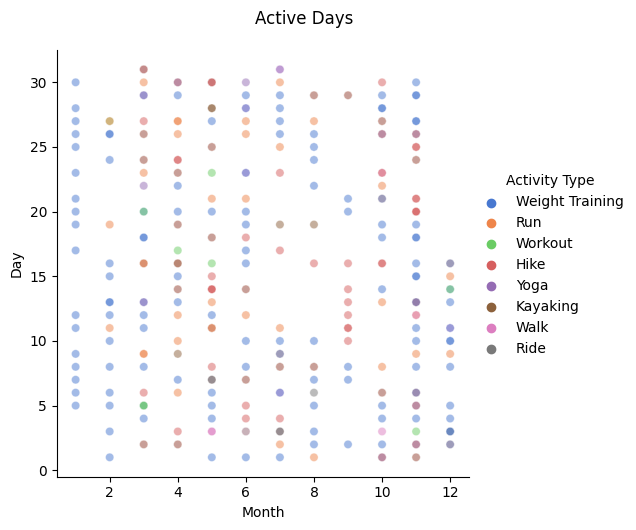

In [19]:
g = sns.relplot(x='activity_month', y='activity_day', kind='scatter',
            hue='Activity Type', alpha=.5, palette="muted", data=df)

g.fig.suptitle('Active Days', y=1.05)

g.set(xlabel='Month', ylabel='Day')

In [20]:
# longest distance activity based on activity type
df.groupby(['Activity Type'], sort=False)['distance_mile'].max()

Activity Type
Weight Training     0.000000
Run                13.272485
Workout             2.895589
Hike               16.491186
Yoga                0.000000
Kayaking            4.709992
Walk                9.109299
Ride               29.359780
Name: distance_mile, dtype: float64

In [21]:
# list those mx activities?
# get temp subset of activities because yoga and weight training doesn't have distance
df_distance = df[df['distance_mile'] > 0]
idx = df_distance.groupby(['Activity Type'])['distance_mile'].transform(max) == df_distance['distance_mile']
df_distance[idx]

,Activity ID,Activity Date,Activity Name,Activity Type,Activity Description,Elapsed Time,Distance,Max Heart Rate,Relative Effort,Commute,Activity Gear,Filename,Athlete Weight,Bike Weight,Elapsed Time.1,Moving Time,Distance.1,Max Speed,Average Speed,Elevation Gain,Elevation Loss,Elevation Low,Elevation High,Max Grade,Average Grade,Average Positive Grade,Average Negative Grade,Max Cadence,Average Cadence,Max Heart Rate.1,Average Heart Rate,Max Watts,Average Watts,Calories,Max Temperature,Average Temperature,Relative Effort.1,Total Work,Number of Runs,Uphill Time,Downhill Time,Other Time,Perceived Exertion,Type,Start Time,Weighted Average Power,Power Count,Prefer Perceived Exertion,Perceived Relative Effort,Commute.1,Total Weight Lifted,From Upload,Grade Adjusted Distance,Weather Observation Time,Weather Condition,Weather Temperature,Apparent Temperature,Dewpoint,Humidity,Weather Pressure,Wind Speed,Wind Gust,Wind Bearing,Precipitation Intensity,Sunrise Time,Sunset Time,Moon Phase,Bike,Gear,Precipitation Probability,Precipitation Type,Cloud Cover,Weather Visibility,UV Index,Weather Ozone,Jump Count,Total Grit,Avg Flow,Flagged,Avg Elapsed Speed,Dirt Distance,Newly Explored Distance,Newly Explored Dirt Distance,Sport Type,activity_date,distance_mile,elevation_gain_ft,activity_month,activity_day
1099,6855522441,"Mar 20, 2022, 4:00:32 PM",Orange Theory Fitness @ Quarry,Workout,Forgot apple watch,3600,4.66,NaN,NaN,False,NaN,NaN,NaN,NaN,3600.0,3600.0,4667.100098,NaN,1.296417,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.296417,0.000000,NaN,NaN,NaN,2022-03-20 16:00:32,2.895589,NaN,3,20
1127,6993873215,"Apr 16, 2022, 10:02:50 PM",Evening Kayaking on Lady Bird Lake,Kayaking,NaN,9599,7.58,NaN,NaN,False,NaN,activities/6993873215.gpx,NaN,NaN,9599.0,6571.0,7584.620117,5.227857,1.154257,10.324402,0.924400,129.199997,140.500000,25.411283,0.123935,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.790147,1705.699951,NaN,NaN,NaN,2022-04-16 22:02:50,4.709992,33.872711,4,16
1253,7819014539,"Sep 16, 2022, 1:21:41 PM","Rim to River to Rim via South Kaibab, Bright A...",Hike,NaN,25449,26.54,NaN,NaN,False,NaN,activities/7819014539.gpx,NaN,NaN,25449.0,20948.0,26547.210938,5.436914,1.267291,1449.818726,1555.119995,754.599976,2192.899902,49.823910,-0.396652,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11027855.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.043153,26547.199219,NaN,NaN,NaN,2022-09-16 13:21:41,16.491186,4756.623268,9,16
1276,8004915309,"Oct 23, 2022, 12:59:48 AM",Evening Walk,Walk,NaN,12865,14.66,NaN,NaN,False,NaN,activities/8004915309.gpx,NaN,NaN,12865.0,12328.0,14667.781250,1.800000,1.189794,53.271328,52.671299,131.500000,150.300003,7.843137,0.004091,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.140131,0.000000,NaN,NaN,NaN,2022-10-23 00:59:48,9.109299,174.774704,10,23
1301,8107727327,"Nov 12, 2022, 2:00:25 PM",Wonderland Trail Half Marathon,Run,NaN,10101,21.36,NaN,NaN,False,NaN,activities/8107727327.gpx,NaN,NaN,10101.0,9616.0,21367.373047,3.588406,2.222065,273.665833,272.966003,202.100006,247.100006,16.110054,0.003278,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,1.0,21940.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10501553.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.115372,4811.200195,NaN,NaN,NaN,2022-11-12 14:0

In [22]:
# longest elapsed time activity based on activity type
df.groupby(['Activity Type'], sort=False)['Elapsed Time'].max()

Activity Type
Weight Training     8906
Run                10101
Workout             3801
Hike               25449
Yoga                3607
Kayaking           12252
Walk               12865
Ride               11823
Name: Elapsed Time, dtype: int64

In [23]:
# what are the longest activities based on time and category
# convert moving time to hours and minutes,  raw data is in seconds
df['friendly_time'] = df['Moving Time'].apply(lambda x: format_timespan(x))
idx = df.groupby(['Activity Type'])['Moving Time'].transform(max) == df['Moving Time']
df[idx][['Activity Date', 'Activity Name', 'Activity Type', 'distance_mile', 'friendly_time']] \
        .sort_values(['friendly_time'], ascending=False)

,Activity Date,Activity Name,Activity Type,distance_mile,friendly_time
1253,"Sep 16, 2022, 1:21:41 PM","Rim to River to Rim via South Kaibab, Bright A...",Hike,16.491186,"5 hours, 49 minutes and 8 seconds"
1276,"Oct 23, 2022, 12:59:48 AM",Evening Walk,Walk,9.109299,"3 hours, 25 minutes and 28 seconds"
1331,"Dec 3, 2022, 3:01:33 PM",Jaguar Memorial Ride for Wounded Warriors Project,Ride,29.359780,"2 hours, 46 minutes and 37 seconds"
1301,"Nov 12, 2022, 2:00:25 PM",Wonderland Trail Half Marathon,Run,13.272485,"2 hours, 40 minutes and 16 seconds"
1052,"Jan 17, 2022, 3:59:00 PM","Fitbod - Back, Biceps, Abs, Lower Back",Weight Training,0.000000,"2 hours, 28 minutes and 26 seconds"
1127,"Apr 16, 2022, 10:02:50 PM",Evening Kayaking on Lady Bird Lake,Kayaking,4.709992,"1 hour, 49 minutes and 31 seconds"
1343,"Dec 14, 2022, 8:15:09 PM","Fitbod - Glutes, Quadriceps, Abs, Adductors, L...",Workout,0.000000,"1 hour, 3 minutes and 21 seconds"
1109,"Mar 29, 2022, 3:30:46 PM",Yoga @ Black Swan,Yoga,0.000000,1 hour and 7 seconds


In [25]:
# Elevation
# What about just elevations not based on activities types
elevation = df[['Activity Date', 'Activity Name', 'Activity Type', 'distance_mile', 'friendly_time', 'elevation_gain_ft']] \
        .sort_values(by=['elevation_gain_ft'], ascending=False).head(10)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'Rim to River to Rim via South Kaibab, Bright Angel Trails'),
  Text(1, 0, 'Angel’s Landing'),
  Text(2, 0, 'Emory Peak'),
  Text(3, 0, 'Bryce Canyon Navajo, Queens Garden, Peek-a-boo, West Rim Trail'),
  Text(4, 0, 'Fairyland Loop'),
  Text(5, 0, 'Afternoon Hike'),
  Text(6, 0, 'Lost Mine Trail'),
  Text(7, 0, 'Lunch Hike'),
  Text(8, 0, 'Lost Maples Hike'),
  Text(9, 0, 'Wonderland Trail Half Marathon')])

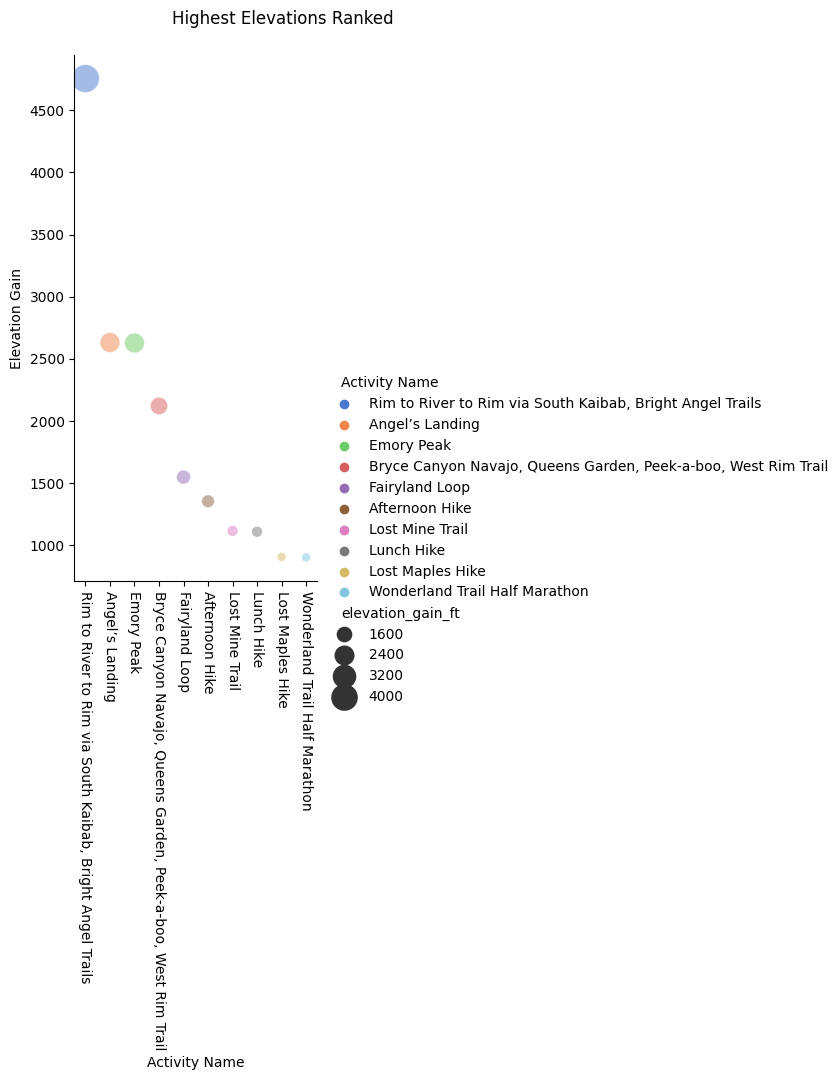

In [27]:
g = sns.relplot(x='Activity Name', y='elevation_gain_ft', kind='scatter', hue='Activity Name', size='elevation_gain_ft',
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=elevation)

g.fig.suptitle('Highest Elevations Ranked', y=1.05)

g.set(xlabel='Activity Name', ylabel='Elevation Gain')

plt.xticks(rotation=-90)

In [28]:
# fastest activity (Run) based on primary activity type
df_run = df[df['Activity Type'] == 'Run']
df_run.sort_values(by=['Average Speed'], ascending=False).head()
# what is the measurement unit for speed?

,Activity ID,Activity Date,Activity Name,Activity Type,Activity Description,Elapsed Time,Distance,Max Heart Rate,Relative Effort,Commute,Activity Gear,Filename,Athlete Weight,Bike Weight,Elapsed Time.1,Moving Time,Distance.1,Max Speed,Average Speed,Elevation Gain,Elevation Loss,Elevation Low,Elevation High,Max Grade,Average Grade,Average Positive Grade,Average Negative Grade,Max Cadence,Average Cadence,Max Heart Rate.1,Average Heart Rate,Max Watts,Average Watts,Calories,Max Temperature,Average Temperature,Relative Effort.1,Total Work,Number of Runs,Uphill Time,Downhill Time,Other Time,Perceived Exertion,Type,Start Time,Weighted Average Power,Power Count,Prefer Perceived Exertion,Perceived Relative Effort,Commute.1,Total Weight Lifted,From Upload,Grade Adjusted Distance,Weather Observation Time,Weather Condition,Weather Temperature,Apparent Temperature,Dewpoint,Humidity,Weather Pressure,Wind Speed,Wind Gust,Wind Bearing,Precipitation Intensity,Sunrise Time,Sunset Time,Moon Phase,Bike,Gear,Precipitation Probability,Precipitation Type,Cloud Cover,Weather Visibility,UV Index,Weather Ozone,Jump Count,Total Grit,Avg Flow,Flagged,Avg Elapsed Speed,Dirt Distance,Newly Explored Distance,Newly Explored Dirt Distance,Sport Type,activity_date,distance_mile,elevation_gain_ft,activity_month,activity_day,friendly_time
1138,7050742493,"Apr 27, 2022, 6:08:32 PM",Afternoon Run with Franki the Corgi,Run,Week 8,514,1.66,NaN,NaN,False,NaN,activities/7050742493.gpx,NaN,NaN,514.0,503.0,1659.004761,4.585185,3.298220,0.000000,0.300000,0.000000,1.100000,0.823142,-0.018192,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.0,1649.599976,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10501553.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,3.227636,0.000000,NaN,NaN,NaN,2022-04-27 18:08:32,1.031476,0.000000,4,27,8 minutes and 23 seconds
1168,7203071788,"May 25, 2022, 11:35:09 PM",Evening Run,Run,NaN,1604,5.13,NaN,NaN,False,NaN,activities/7203071788.gpx,NaN,NaN,1604.0,1604.0,5132.724609,5.408672,3.199953,7.725000,7.725000,0.600000,3.900000,7.057767,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.0,5011.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10501553.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,3.199953,140.199997,NaN,NaN,NaN,2022-05-25 23:35:09,3.187633,25.344489,5,25,26 minutes and 44 seconds
1102,6870537918,"Mar 23, 2022, 4:22:00 PM",Lunch Run with Franki the Corgi,Run,Week 3,637,1.69,NaN,NaN,False,NaN,activities/6870537918.gpx,NaN,NaN,637.0,530.0,1690.379272,5.252385,3.189395,3.286667,3.386670,187.399994,191.399994,3.561197,-0.005951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,1.0,1687.900024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6836084.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.653657,0.000000,NaN,NaN,NaN,2022-03-23 16:22:00,1.050117,10.783027,3,23,8 minutes and 50 seconds
1226,7567121941,"Aug 1, 2022, 11:15:58 PM",Evening Run - Run For Chinatown,Run,NaN,3267,8.90,NaN,NaN,False,NaN,activities/7567121941.gpx,NaN,NaN,3267.0,2838.0,8906.863281,6.734996,3.138430,19.382143,18.082100,2.200000,16.000000,11.026973,0.015556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,1.0,8389.900391,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10501553.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.726313,0.000000,NaN,NaN,NaN,2022-08-01 23:15:58,5.530202,63.589710,8,1,47 minutes and 18 seconds
1163,7166158549,"May 18, 2022, 11:31:44 PM",Evening Run,Run,NaN,1648,5.04,NaN,NaN,False,NaN,activities/7166158549.gpx,NaN,NaN,1648.0,1610.0,5048.149414,4.345315,3.135496,7.832143,7.832143,0.600000,3.900000,6.413042,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.0,5058.200195,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [29]:
# longest run
df_run.sort_values(by=['distance_mile'], ascending=False).head()

,Activity ID,Activity Date,Activity Name,Activity Type,Activity Description,Elapsed Time,Distance,Max Heart Rate,Relative Effort,Commute,Activity Gear,Filename,Athlete Weight,Bike Weight,Elapsed Time.1,Moving Time,Distance.1,Max Speed,Average Speed,Elevation Gain,Elevation Loss,Elevation Low,Elevation High,Max Grade,Average Grade,Average Positive Grade,Average Negative Grade,Max Cadence,Average Cadence,Max Heart Rate.1,Average Heart Rate,Max Watts,Average Watts,Calories,Max Temperature,Average Temperature,Relative Effort.1,Total Work,Number of Runs,Uphill Time,Downhill Time,Other Time,Perceived Exertion,Type,Start Time,Weighted Average Power,Power Count,Prefer Perceived Exertion,Perceived Relative Effort,Commute.1,Total Weight Lifted,From Upload,Grade Adjusted Distance,Weather Observation Time,Weather Condition,Weather Temperature,Apparent Temperature,Dewpoint,Humidity,Weather Pressure,Wind Speed,Wind Gust,Wind Bearing,Precipitation Intensity,Sunrise Time,Sunset Time,Moon Phase,Bike,Gear,Precipitation Probability,Precipitation Type,Cloud Cover,Weather Visibility,UV Index,Weather Ozone,Jump Count,Total Grit,Avg Flow,Flagged,Avg Elapsed Speed,Dirt Distance,Newly Explored Distance,Newly Explored Dirt Distance,Sport Type,activity_date,distance_mile,elevation_gain_ft,activity_month,activity_day,friendly_time
1301,8107727327,"Nov 12, 2022, 2:00:25 PM",Wonderland Trail Half Marathon,Run,NaN,10101,21.36,NaN,NaN,False,NaN,activities/8107727327.gpx,NaN,NaN,10101.0,9616.0,21367.373047,3.588406,2.222065,273.665833,272.966003,202.100006,247.100006,16.110054,0.003278,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,1.0,21940.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10501553.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.115372,4811.200195,NaN,NaN,NaN,2022-11-12 14:00:25,13.272485,897.853810,11,12,"2 hours, 40 minutes and 16 seconds"
1134,7030624798,"Apr 23, 2022, 11:07:30 PM",Evening Run pacing Frank the 100 Mile Man,Run,NaN,5755,9.92,NaN,NaN,False,NaN,activities/7030624798.gpx,NaN,NaN,5755.0,4687.0,9923.550781,3.713704,2.117250,31.335587,59.035599,231.899994,264.500000,5.953675,-0.279254,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,1.0,9924.700195,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6836084.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.724336,46.099998,NaN,NaN,NaN,2022-04-23 23:07:30,6.164000,102.807046,4,23,"1 hour, 18 minutes and 7 seconds"
1241,7709973411,"Aug 27, 2022, 3:21:12 PM",Lunch Run,Run,My favorite place to run 🤩,3598,9.87,NaN,NaN,False,NaN,activities/7709973411.gpx,NaN,NaN,3598.0,3559.0,9877.250977,5.456392,2.775288,83.006943,83.106903,9.500000,38.599998,6.452906,-0.001012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,1.0,9983.099609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10501553.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.745206,0.000000,NaN,NaN,NaN,2022-08-27 15:21:12,6.132932,272.332498,8,27,59 minutes and 19 seconds
1174,7228057899,"May 30, 2022, 4:55:40 PM",Morning Run,Run,NaN,4133,9.68,NaN,NaN,False,NaN,activities/7228057899.gpx,NaN,NaN,4133.0,4119.0,9681.589844,4.811914,2.350471,130.128845,132.729004,3.200000,104.400002,37.533710,-0.026855,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,1.0,10054.599609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10501553.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.342509,4565.700195,NaN,NaN,NaN,2022-05-30 16:55:40,6.014871,426.931921,5,30,"1 hour, 8 minutes and 39 seconds"
1226,7567121941,"Aug 1, 2022, 11:15:58 PM",Evening Run - Run For Chinatown,Run,NaN,3267,8.90,NaN,NaN,False,NaN,activities/7567121941.gpx,NaN,NaN,3267.0,2838.0,8906.863281,6.734996,3.138430,19.382143,18.082100,2.200000,16.000000,11.026973,0.015556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [ ]:
# df_activity[['Activity ID', 'Filename']].to_pickle('activities.pkl')
# refer to parse_gpx_activies.py for parsing and importing location data from .gpx to dataframe

In [30]:
df_locations = pd.read_pickle('locations.pkl')

In [31]:
df_locations.head()

,latitude,longitude,elevation,activity_name
0,29.461666,-98.474077,204.8,6664071378
1,29.461698,-98.474030,204.8,6664071378
2,29.461764,-98.473920,204.8,6664071378
3,29.461765,-98.473908,204.8,6664071378
4,29.461814,-98.473726,204.8,6664071378


In [32]:
# join the two dfs
df_locations['activity_name'] = df_locations['activity_name'].astype(int)
merged_df = pd.merge(df, df_locations, left_on='Activity ID', right_on='activity_name')

In [33]:
# drop duplicated activity ID
merged_df.drop('activity_name', axis=1, inplace=True)

In [34]:
len(merged_df)

21156552

In [2]:
# merged_df.to_pickle('merged_activity_location.pkl')
# merged_df = pd.read_pickle('merged_activity_location.pkl')

In [3]:
# converting to geopandas
gdf = gpd.GeoDataFrame(merged_df, geometry=gpd.points_from_xy(merged_df.longitude, merged_df.latitude))

In [4]:
len(gdf)

21156552

In [23]:
# states = gpd.read_file('./cb_2018_states/cb_2018_us_state_5m.shp')
# states = states.to_crs("EPSG:3395")
# drop alaska, hawaii etc
# values = ['Hawaii', 'Alaska', 'Commonwealth of the Northern Mariana Islands', 'Guam', \
#           'United States Virgin Islands', 'American Samoa']

#drop rows that contain any value in the list
# states = states[states.NAME.isin(values) == False]

In [6]:
# sample down each activity by its first data point
sample_gdf = gdf.groupby('Activity ID').first()

In [35]:
# print(sample_gdf.iloc[0].geometry)
# states.intersects(sample_gdf.iloc[0].geometry)

In [50]:
# g, ax = plt.subplots(figsize=(12, 12))
# states.plot(ax=ax, facecolor='Grey', cmap='cividis')

# sample_gdf.plot(ax=ax, color='red',markersize=sample_gdf.elevation_gain_ft, alpha=0.5);

In [59]:
map = folium.Map(location=[36, -100],
               zoom_start=4,
               zoom_control=False,
               scrollWheelZoom=False,
               dragging=False)

frequency_data = [[point.xy[1][0], point.xy[0][0]] for point in sample_gdf.geometry]

plugins.MarkerCluster(frequency_data).add_to(map)

map